<a href="https://colab.research.google.com/github/droidadroit/age-and-gender-classification/blob/master/AgeGender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Directory structure

content  
-------- gdrive  
---------------- My Drive  
------------------------ **AgeGenderClassification**  
-------------------------------- **data**  
-------------------------------- **models**  
-------------------------------- **results**  
-------------------------------- **AgeGender.ipynb**


In [2]:
#!pip3 install torch torchvision torchaudio
# install libraries

## Imports

In [3]:
import torch
import torch.autograd.variable as Variable
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as utils
from torch.utils.data import Dataset, DataLoader
from torchvision import models

In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from shutil import copyfile

# Preparing dataloaders

In [5]:
# paths to data

PATH_TO_FOLDS = "/content/gdrive/My Drive/AgeGenderClassification/data/train_val_txt_files_per_fold"
PATH_TO_DATA = "/content/gdrive/My Drive/AgeGenderClassification/data"
PATH_TO_IMAGE_FOLDERS = PATH_TO_DATA + "/aligned"

### Creating a Dataset class


In [6]:
class AdienceDataset(Dataset):

    def __init__(self, txt_file, root_dir, transform):
        self.txt_file = txt_file
        self.root_dir = root_dir
        self.transform = transform
        self.data = self.read_from_txt_file()

    def __len__(self):
        return len(self.data)

    def read_from_txt_file(self):
        data = []
        f = open(self.txt_file)
        for line in f.readlines():
            image_file, label = line.split()
            label = int(label)
            # if 'gender' in self.txt_file:
            #     label +=8
            data.append((image_file, label))
        return data

    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        image = Image.open(self.root_dir + '/' + img_name)

        if self.transform:
            image = self.transform(image)

        return {
            'image': image,
            'label': label
        }

### Transforms
Every image is first resized to a `256x256` image and then cropped to a `227x227` image before being fed to the network.

**`transforms_list`** is the list of transforms we apply to the input data. We can train the network using the following data augmentation techniques:
*   random horizontal flip
*   random crop and random horizontal flip


In [7]:
transforms_list = [
    transforms.Resize(256),
    transforms.CenterCrop(227),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.RandomCrop(227)
]

transforms_dict = {
    'train': {
        0: list(transforms_list[i] for i in [0, 1, 3]),        # no transformation
        1: list(transforms_list[i] for i in [0, 1, 2, 3]),     # random horizontal flip
        2: list(transforms_list[i] for i in [0, 4, 2, 3])      # random crop and random horizontal flip
    },
    'val': {
        0: list(transforms_list[i] for i in [0, 1, 3])
    },
    'test': {
        0: list(transforms_list[i] for i in [0, 1, 3])
    }
}

### Dataloader


In [8]:
def get_dataloader(s, c, fold, transform_index, minibatch_size):

    txt_file = f'{PATH_TO_FOLDS}/test_fold_is_{fold}/{c}_{s}.txt'
    root_dir = PATH_TO_IMAGE_FOLDERS

    transformed_dataset = AdienceDataset(txt_file, root_dir,
                                         transforms.Compose(transforms_dict[s][transform_index]))
    dataloader = DataLoader(transformed_dataset, batch_size=minibatch_size, shuffle=True, num_workers=2)

    return dataloader

# Network

### Using the GPU

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
device

device(type='cuda', index=0)

In [11]:
PATH_TO_MODELS = "/content/gdrive/My Drive/AgeGenderClassification/models"

## Defining the network

In [12]:
class AgeGenderClassifier(nn.Module):
    def __init__(self, num_classes):
        super(AgeGenderClassifier, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        # Remove the last fully connected layer of ResNet-50
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])
        # Add custom fully connected layer for age/gender
        self.fc = nn.Linear(2048, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        features = self.resnet(x)
        features = features.view(features.size(0), -1)
        output = self.log_softmax(self.fc(features))
        return output


In [11]:
m = AgeGenderClassifier(2)
print(m) # printing a network for 2 classes i.e. gender prediction

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 138MB/s]


AgeGenderClassifier(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): 

## Hyperparameters

In [13]:
# same as Levi Hassner CNN
minibatch_size = 50
num_epochs = 5
lr = 0.0001
criterion = nn.NLLLoss()

## Training the network

In [14]:
def train(net, train_dataloader, epochs, filename, checkpoint_frequency, val_dataloader=None):

    net.train()
    optimizer = optim.Adam(net.parameters(), lr)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 50)
    # not using scheduler because of a small number of epochs
    training_loss, validation_loss = [], []
    checkpoint = 0
    iteration = 0
    running_loss = 0

    for epoch in range(epochs):

        for i, batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += float(loss.item())
            loss.backward()
            optimizer.step()
            #scheduler.step()

            if (iteration+1) % checkpoint_frequency == 0 and val_dataloader is not None:
                training_loss.append(running_loss/checkpoint_frequency)
                validation_loss.append(validate(net, val_dataloader))
                print(f'minibatch:{i}, epoch:{epoch}, iteration:{iteration}, training_error:{training_loss[-1]}, validation_error:{validation_loss[-1]}')
                checkpoint += 1
                running_loss = 0

            iteration += 1


    save_network(net, f'{filename}_checkpoint{checkpoint}')
    return net, training_loss, validation_loss

## Validation
We evaluate the performance (in terms of loss) of the trained network on validation set.

In [15]:
def validate(net, dataloader):
    net.train()
    total_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            total_loss += float(loss.item())

    return total_loss/(i+1)

In [16]:
def get_validation_error(c, fold, train_transform_index):
    filename = get_model_filename(c, fold, train_transform_index)
    num_classes = 0
    if c == 'age':
      num_classes = 8
    else:
      num_classes = 2
    net = AgeGenderClassifier(num_classes).to(device)
    net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{filename}'))
    return validate(net, get_dataloader('val', c, fold, 0, minibatch_size))

## Testing
We evaluate the performance (in terms of accuracy) of the trained network on the test set.

In [17]:
def test(net, dataloader, c):
    result = {
        'exact_match': 0,
        'total': 0
    }
    if c == 'age':
        result['one_off_match'] = 0

    total_loss = 0

    with torch.no_grad():
        net.eval()
        for i, batch in enumerate(dataloader):
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)

            loss = criterion(outputs, labels)
            total_loss += float(loss.item())

            outputs = torch.tensor(list(map(lambda x: torch.max(x, 0)[1], outputs))).to(device)
            result['total'] += len(outputs)
            result['exact_match'] += sum(outputs == labels).item()
            if c == 'age':
                result['one_off_match'] += (sum(outputs==labels) +
                                            sum(outputs==labels-1) +
                                            sum(outputs==labels+1)).item()

    result['test_loss'] = total_loss/(i+1)
    return result

## Saving the network

In [18]:
def save_network(net, filename):
    torch.save(net.state_dict(), f'{PATH_TO_MODELS}/{filename}.pt')

# Execution

**`train_save()`** trains the network using the **`train()`** function. This function also plots a graph of training and validation errors over the iterations.



In [19]:
def train_save(c, fold, train_transform_index, num_classes, checkpoint_frequency=50):

    model = AgeGenderClassifier(num_classes).to(device)
    for param in model.resnet.parameters():
      param.requires_grad = False # only train the last linear layer by freezing the rest

    trained_net, training_loss, validation_loss = train(
        model,
        get_dataloader('train', c, fold, train_transform_index, minibatch_size),
        num_epochs,
        f'{fold}_{c}_train_{train_transform_index}',
        checkpoint_frequency,
        get_dataloader('val', c, fold, 0, minibatch_size)
    )

    plt.plot(list(map(lambda x: checkpoint_frequency * x, (list(range(1, len(validation_loss)+1))))), validation_loss, label='validation_loss')
    plt.plot(list(map(lambda x: checkpoint_frequency * x, (list(range(1, len(training_loss)+1))))), training_loss, label='training_loss')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.show()

    return validation_loss

### Picking the best model among all the folds

Using **`pick_best_model()`**, we can pick the model among various folds that gives us the best validation accuracy. The best model's name is appended with **_best **in the **models** directory.

In [20]:
def pick_best_model(c):

    def fn_filter(file):
        file_split = file.split('_')
        return True if (len(file_split) == 5 and file_split[1] == c) else False

    def fn_map(file):
        file_split = file.split('_')
        return get_validation_error(c, file_split[0], file_split[3])

    files = list(filter(fn_filter, os.listdir(PATH_TO_MODELS)))
    val_errors = list(map(fn_map, files))
    min_val_error, file = min(zip(val_errors, files))
    best_model = f'{PATH_TO_MODELS}/{file.split(".")[0]}_best.pt'
    copyfile(f'{PATH_TO_MODELS}/{file}', best_model)

    print(f'Picking {best_model} as the best model for {c}...')

### Calculating performance/accuracy

We can check the performance of any model using the **`get_performance()`** function.


In [21]:
def get_performance(c):

    file = get_best_model_filename(c).split('_')
    return get_performance_of_a_model('test', file[1], file[0], file[3])

In [22]:
def get_best_model_filename(c):
    def fn_filter(file):
        file_split = file.split('_')
        return True if (len(file_split) == 6 and file_split[1] == c) else False

    return list(filter(fn_filter, os.listdir(PATH_TO_MODELS)))[0]

In [23]:
def get_performance_of_a_model(s, c, fold, train_transform_index):

    filename = get_model_filename(c, fold, train_transform_index)
    num_classes = 0
    if c == 'age':
      num_classes = 8
    else:
      num_classes = 2
    net = AgeGenderClassifier(num_classes).to(device)
    net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{filename}'))
    performance = test(
        net,
        get_dataloader(s, c, fold, 0, minibatch_size),
        c
    )
    if c == 'age':
        return {
            'accuracy': performance['exact_match']/performance['total'],
            'one-off accuracy': performance['one_off_match']/performance['total'],
            'test loss': performance['test_loss']
        }
    elif c == 'gender':
        return {
            'accuracy': performance['exact_match']/performance['total'],
            'test loss': performance['test_loss']
        }

In [24]:
def get_model_filename(c, fold, train_transform_index):
    start_of_filename = f'{fold}_{c}_train_{train_transform_index}_checkpoint'
    for file in os.listdir(PATH_TO_MODELS):
        if file.startswith(start_of_filename):
            return file

##Performing training and testing
For age and gender classification, train on 5 folds and select the model that gives the smallest validation error.

gender fold 0


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 68.5MB/s]


minibatch:49, epoch:0, iteration:49, training_error:0.6818359243869782, validation_error:0.6627883977360196
minibatch:99, epoch:0, iteration:99, training_error:0.6546044516563415, validation_error:0.641217827796936
minibatch:149, epoch:0, iteration:149, training_error:0.6301058757305146, validation_error:0.6182848855301186
minibatch:199, epoch:0, iteration:199, training_error:0.6147602224349975, validation_error:0.6033007789541174
minibatch:3, epoch:1, iteration:249, training_error:0.5991736567020416, validation_error:0.5870624604048552
minibatch:53, epoch:1, iteration:299, training_error:0.5894189620018006, validation_error:0.5780942241350809
minibatch:103, epoch:1, iteration:349, training_error:0.5723234498500824, validation_error:0.5684488305339107
minibatch:153, epoch:1, iteration:399, training_error:0.5606601405143737, validation_error:0.5516392588615417
minibatch:203, epoch:1, iteration:449, training_error:0.5559866482019424, validation_error:0.5490985049141778
minibatch:7, epoch

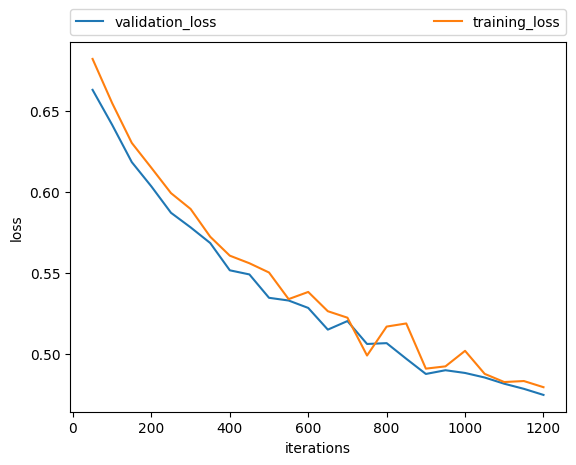

gender fold 1


KeyboardInterrupt: ignored

In [25]:
import time

for model_type in [['gender', 2], ['age', 8]]:

    start_time = time.time()

    for fold in range(5):
      print(f"{model_type[0]} fold {fold}")
      train_save(model_type[0], fold, 2, model_type[1])
    pick_best_model(model_type[0])

    end_time = time.time()
    duration = end_time - start_time
    print(f"Time taken for training on {model_type[0]}: {duration} seconds")


In [60]:
get_performance('age')

{'accuracy': 0.5282669138090825,
 'one-off accuracy': 0.7486098239110287,
 'test loss': 1.498770461685356}

In [26]:
get_performance('gender')

{'accuracy': 0.7736461192912403, 'test loss': 0.4825645195849148}